- - - 

**Подключение библиотек и скриптов**

In [16641]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import random
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import catboost as catb

In [16642]:
import warnings
warnings.filterwarnings('ignore')

In [16643]:
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [16644]:
# input
DATASET_PATH = '../course_project/course_project_train.csv'
DATASET_PATH_test = '../course_project/course_project_test.csv'
# output
PREP_DATASET_PATH = '../course_project/course_project_train_prep.csv'

In [16645]:
#Функция изменения типа данных признаков.
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('str')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Загрузка данных**

In [16646]:
df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(DATASET_PATH_test)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [16647]:
df.shape, test_df.shape

((7500, 17), (2500, 16))

In [16648]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Обзор данных<a class="anchor" id="review"></a>

**Обзор целевой переменной**

In [16649]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [16650]:
# наблюдается дисбаланс, потребуется балансировка

**Обзор количественных признаков**

In [16651]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [16652]:
#наблюдаются выбросы справа у признаков 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Current Loan Amount'
# Current Credit Balance, Monthly Debt, Credit Score.

In [16653]:
#преобразование вещетсвенных признаков для экономии ресурсов
df = reduce_mem_usage(df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.58 MB
Decreased by 40.4%


In [16654]:
#преобразование вещетсвенных признаков для экономии ресурсов
test_df = reduce_mem_usage(df)

Memory usage of dataframe is 0.58 MB
Memory usage after optimization is: 0.58 MB
Decreased by 0.0%


**Обзор номинативных признаков**

In [16655]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

**считаю целесообразным выразить значения признаков через их количество**

### Обработка пропусков<a class="anchor" id="gaps"></a>

In [16656]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

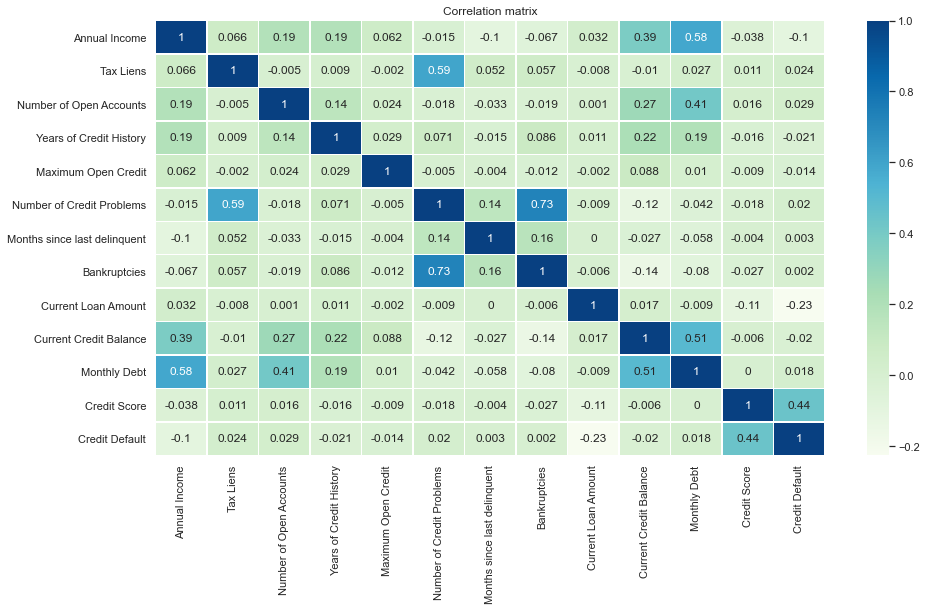

In [16657]:
#Матрица корреляций для определения связанных признаков.
plt.figure(figsize = (15,8))

sns.set(font_scale=1)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**'Annual Income'**

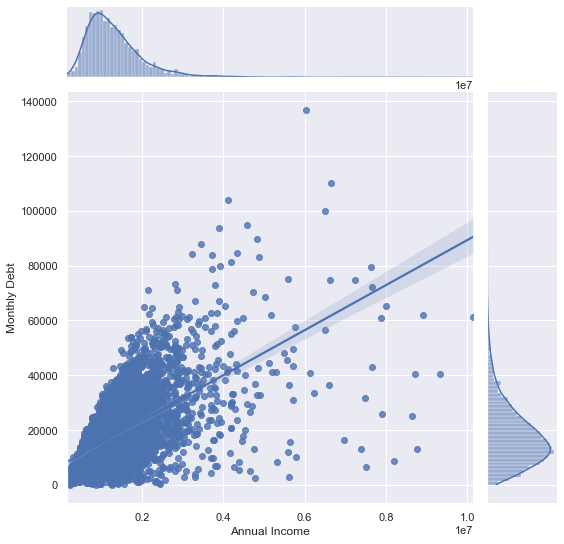

In [16658]:
#sns.relplot(x='Monthly Debt', y='Annual Income', data=df);
grid = sns.jointplot(df['Annual Income'], df['Monthly Debt'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

*'Annual Income' и 'Monthly Debt' имеют высокую степнь корреляции (зависимость близкая к линейной). Выразим их зависимость
через коэффициент и с его помощью заполним пропуски 'Annual Income'*  

In [16659]:
df['AI_nan'] = 0
df.loc[df['Annual Income'].isna(), 'AI_nan'] = 1
df['K_AI_MD'] = np.where((df['Annual Income'].notna() & df['Monthly Debt'].notna() & df['Monthly Debt'] != 0),\
                df['Annual Income'] / df['Monthly Debt'], 0)

In [16660]:
df['Annual Income'] = np.where(df['Annual Income'].isna(),\
                 df['K_AI_MD'].median() * df['Monthly Debt'], df['Annual Income'])

In [16661]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float32
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float32
 4   Number of Open Accounts       7500 non-null   float32
 5   Years of Credit History       7500 non-null   float32
 6   Maximum Open Credit           7500 non-null   float32
 7   Number of Credit Problems     7500 non-null   float32
 8   Months since last delinquent  3419 non-null   float32
 9   Bankruptcies                  7486 non-null   float32
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float32
 13  Cur

**'Months since last delinquent'**

* Пропуски "Months since last delinquent" устраняем в три этапа, поскольку ни один из связаных признаков не дает 100%* *заполнения.*
*Если 'Number of Credit Problems' == 0, то пропуски "Months since last delinquent" заменяем "бесконечно большим" значением,* 
чтобы облегчить обучение (выбрал 9999).*
*Если 'Bankruptcies' == 0 b Credit Default == 0, то пропуски "Months since last delinquent" заменяем 9999.*
*Если 'Number of Credit Problems' != 0, то пропуски "Months since last delinquent" заменяем медианой.*

In [16662]:
#служебный признак обозначающий, что значения исходного признака были скорректированы
df['MSLD_nan'] = 0

In [16663]:
#служебный признак обозначающий, что значения исходного признака были скорректированы
test_df['MSLD_nan'] = 0

In [16664]:
#1 Months since last delinquent
df['MSLD_nan'] = np.where((df['Months since last delinquent'].isna()) & (df['Current Loan Amount']>800000), 1, df['MSLD_nan'])
df['Months since last delinquent'] = np.where((df['Months since last delinquent'].isna()) &\
                                              (df['Current Loan Amount']>800000), 9999, df['Months since last delinquent'])

In [16665]:
#1 Months since last delinquent
test_df['MSLD_nan'] = np.where((test_df['Months since last delinquent'].isna()) & (test_df['Current Loan Amount']>800000),\
                               1, test_df['MSLD_nan'])
test_df['Months since last delinquent'] = np.where((test_df['Months since last delinquent'].isna()) &\
                                         (test_df['Current Loan Amount']>800000), 9999, test_df['Months since last delinquent'])

In [16666]:
#2Months since last delinquent пунктов к F1
df['MSLD_nan'] = np.where((df['Months since last delinquent'].isna()) & (df['Bankruptcies'] == 0) \
                          , 2, df['MSLD_nan'])
df['Months since last delinquent'] = np.where((df['Months since last delinquent'].isna()) & (df['Bankruptcies'] == 0)\
                                   , 9999, df['Months since last delinquent'])

In [16667]:
#2Months since last delinquent пунктов к F1
test_df['MSLD_nan'] = np.where((test_df['Months since last delinquent'].isna()) & (test_df['Bankruptcies'] == 0),\
                          2, test_df['MSLD_nan'])
test_df['Months since last delinquent'] = np.where((test_df['Months since last delinquent'].isna()) &\
                                                 (test_df['Bankruptcies'] == 0), 9999, test_df['Months since last delinquent'])

In [16668]:
##3Months since last delinquent
df['MSLD_nan'] = np.where((df['Months since last delinquent'].isna()) & (df['Number of Credit Problems'] == 0),3,df['MSLD_nan'])
df['Months since last delinquent'] = np.where((df['Months since last delinquent'].isna()) & \
                                    (df['Number of Credit Problems'] == 0),9999, df['Months since last delinquent'])

In [16669]:
##3Months since last delinquent
test_df['MSLD_nan'] = np.where((test_df['Months since last delinquent'].isna()) & (test_df['Number of Credit Problems'] == 0)\
                               ,3,test_df['MSLD_nan'])
test_df['Months since last delinquent'] = np.where((test_df['Months since last delinquent'].isna()) & \
                                    (test_df['Number of Credit Problems'] == 0),9999, test_df['Months since last delinquent'])

In [16670]:
##4Months since last delinquent
df['MSLD_nan'] = np.where((df['Months since last delinquent'].isna()) &\
                                    (df['Number of Credit Problems'] != 0), 4, df['MSLD_nan'])
df['Months since last delinquent'] = np.where((df['Months since last delinquent'].isna()) &\
                                    (df['Number of Credit Problems'] != 0), df['Months since last delinquent'].median(),\
                                    df['Months since last delinquent'])

In [16671]:
##4Months since last delinquent
test_df['MSLD_nan'] = np.where((test_df['Months since last delinquent'].isna()) &\
                                    (test_df['Number of Credit Problems'] != 0), 4, test_df['MSLD_nan'])
test_df['Months since last delinquent'] = np.where((test_df['Months since last delinquent'].isna()) &\
                                 (test_df['Number of Credit Problems'] != 0), test_df['Months since last delinquent'].median(),\
                                 test_df['Months since last delinquent'])

**Bankruptcies**

In [16672]:
#служебный признак обозначающий, что значения исходного признака были скорректированы
df['B_nan'] = 0
df.loc[df['Bankruptcies'].isna(), 'B_nan'] = 1
df['Bankruptcies'] = np.where((df['Bankruptcies'].isna()) &\
                                    (df['Number of Credit Problems'] == 0), 0, df['Bankruptcies'])

In [16673]:
#служебный признак обозначающий, что значения исходного признака были скорректированы
test_df['B_nan'] = 0
test_df.loc[df['Bankruptcies'].isna(), 'B_nan'] = 1
test_df['Bankruptcies'] = np.where((test_df['Bankruptcies'].isna()) &\
                                    (test_df['Number of Credit Problems'] == 0), 0, test_df['Bankruptcies'])

In [16674]:
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,AI_nan,K_AI_MD,MSLD_nan,B_nan
count,7500.00,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,7500.000000,7500.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.0
mean,1316056.00,0.030133,11.130934,18.317446,9.451526e+05,0.1700,5456.867676,0.116933,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733,0.207600,89.854843,1.130000,0.0
std,829652.50,0.271613,4.908937,7.041938,1.602614e+07,0.4986,4962.947754,0.346901,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874,0.405616,280.086273,1.161815,0.0
min,0.00,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,799149.25,0.000000,8.000000,13.500000,2.792295e+05,0.0000,35.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000,0.000000,38.834849,0.000000,0.0
50%,1143439.00,0.000000,10.000000,17.000000,4.781590e+05,0.0000,9999.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000,0.000000,60.913776,1.000000,0.0
75%,1606388.25,0.000000,14.000000,21.799999,7.935015e+05,0.0000,9999.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000,0.000000,93.813658,2.000000,0.0
max,10149344.00,7.000000,43.000000,57.700001,1.304726e+09,7.0000,9999.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000,1.000000,17124.000000,4.000000,0.0


**Credit Score**

In [16675]:
df.loc[df['Credit Score'].isna(), 'Credit Score'] = df['Credit Score'].median()

In [16676]:
#поскольку высокой корреляции с другими признаками, за исключение таргета нет, а полиномиальную регрессию мы на курсе
#не изучали то ввиду п8. требований, заменяю на медиану
test_df.loc[test_df['Credit Score'].isna(), 'Credit Score'] = test_df['Credit Score'].median()

In [16677]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,AI_nan,K_AI_MD,MSLD_nan,B_nan
count,7500.00,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,7500.000000,7500.000000,7500.0,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.0
mean,1316056.00,0.030133,11.130934,18.317446,9.451526e+05,0.1700,5456.867676,0.116933,11873135.0,2.898332e+05,18314.453125,1063.877319,0.281733,0.207600,89.854843,1.130000,0.0
std,829652.50,0.271613,4.908937,7.041938,1.602614e+07,0.4986,4962.947754,0.346901,31926302.0,3.178713e+05,11926.758789,1438.325317,0.449874,0.405616,280.086273,1.161815,0.0
min,0.00,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,799149.25,0.000000,8.000000,13.500000,2.792295e+05,0.0000,35.000000,0.000000,180169.0,1.142565e+05,10067.500000,718.000000,0.000000,0.000000,38.834849,0.000000,0.0
50%,1143439.00,0.000000,10.000000,17.000000,4.781590e+05,0.0000,9999.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000,0.000000,60.913776,1.000000,0.0
75%,1606388.25,0.000000,14.000000,21.799999,7.935015e+05,0.0000,9999.000000,0.000000,519882.0,3.604062e+05,23818.000000,740.000000,1.000000,0.000000,93.813658,2.000000,0.0
max,10149344.00,7.000000,43.000000,57.700001,1.304726e+09,7.0000,9999.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000,1.000000,17124.000000,4.000000,0.0


### Обработка выбросов<a class="anchor" id="outliers"></a>

In [16678]:
#замена "сверхквантильных", нулевых, пропущенных значений на медиану
def replace_median (df, feature, quantile):
    quant = df[feature].quantile(quantile)
    median = df[feature].median()
    df[feature] = np.where((df[feature] > quant) | (df[feature] == 0) | (df[feature].isna()), median, df[feature])

In [16679]:
# CS_target - служебный признак, для обозначений наблюдений со 100% значением Credit Default ==1
df['CS_target'] = 0
df.loc[(df['Credit Score'] > (df['Credit Score'].median() * 8)) & (df['Credit Default'] == 1),\
                                                           'CS_target'] = 1
df['CS_target'] = df['CS_target'].astype('category')

In [16680]:
# CS_target - служебный признак, для обозначений наблюдений со 100% значением Credit Default ==1
test_df['CS_target'] = 0
test_df.loc[(test_df['Credit Score'] > (test_df['Credit Score'].median() * 8)) & (test_df['Credit Default'] == 1),\
                                                           'CS_target'] = 1
test_df['CS_target'] = test_df['CS_target'].astype('category')

In [16681]:
#Замена выбросов, превышающих квантильное значение на медиану
AI_quant = df['Annual Income'].quantile(0.975)
df.loc[df['Annual Income'] > AI_quant, 'Annual Income'] = replace_median(df, 'Annual Income', 0.975)

In [16682]:
#Замена выбросов, превышающих квантильное значение на медиану
AI_quant = test_df['Annual Income'].quantile(0.975)
test_df.loc[df['Annual Income'] > AI_quant, 'Annual Income'] = replace_median(test_df, 'Annual Income', 0.975)

In [16683]:
#Замена выбросов, превышающих квантильное значение на медиану
NOA_quant = df['Number of Open Accounts'].quantile(0.975)
df.loc[df['Number of Open Accounts'] > NOA_quant, 'Number of Open Accounts'] = \
replace_median(df,'Number of Open Accounts', 0.975)

In [16684]:
#Замена выбросов, превышающих квантильное значение на медиану
NOA_quant = test_df['Number of Open Accounts'].quantile(0.975)
test_df.loc[df['Number of Open Accounts'] > NOA_quant, 'Number of Open Accounts'] = \
replace_median(test_df,'Number of Open Accounts', 0.975)

In [16685]:
#Замена выбросов, превышающих квантильное значение на медиану
CLA_quant = df['Current Loan Amount'].quantile(0.975)
df.loc[df['Current Loan Amount'] > CLA_quant, 'Current Loan Amount'] = replace_median(df, 'Current Loan Amount', 0.975)

In [16686]:
#Замена выбросов, превышающих квантильное значение на медиану
CLA_quant = test_df['Current Loan Amount'].quantile(0.975)
df.loc[test_df['Current Loan Amount'] > CLA_quant, 'Current Loan Amount'] =\
                                                                    replace_median(test_df, 'Current Loan Amount', 0.975)

In [16687]:
#Замена выбросов, превышающих квантильное значение на медиану
MD_quant = df['Monthly Debt'].quantile(0.975)
df.loc[df['Monthly Debt'] > MD_quant, 'Monthly Debt'] = replace_median(df, 'Monthly Debt', 0.975)

In [16688]:
#Замена выбросов, превышающих квантильное значение на медиану
MD_quant = test_df['Monthly Debt'].quantile(0.975)
df.loc[test_df['Monthly Debt'] > MD_quant, 'Monthly Debt'] = replace_median(df, 'Monthly Debt', 0.975)

In [16689]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,AI_nan,K_AI_MD,MSLD_nan,B_nan
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,7500.000000,7500.000000,7500.0,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.0
mean,1.183197e+06,0.030133,10.446667,18.317446,9.451526e+05,0.1700,5456.867676,0.116933,11873135.0,2.898332e+05,16534.078125,1063.877319,0.281733,0.207600,89.854843,1.130000,0.0
std,5.276491e+05,0.271613,3.827498,7.041938,1.602614e+07,0.4986,4962.947754,0.346901,31926302.0,3.178713e+05,8644.821289,1438.325317,0.449874,0.405616,280.086273,1.161815,0.0
min,1.035534e+03,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,17.000000,585.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,7.995770e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,35.000000,0.000000,180169.0,1.142565e+05,10102.750000,718.000000,0.000000,0.000000,38.834849,0.000000,0.0
50%,1.143439e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,9999.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000,0.000000,60.913776,1.000000,0.0
75%,1.496896e+06,0.000000,13.000000,21.799999,7.935015e+05,0.0000,9999.000000,0.000000,519882.0,3.604062e+05,21932.500000,740.000000,1.000000,0.000000,93.813658,2.000000,0.0
max,2.775083e+06,7.000000,20.000000,57.700001,1.304726e+09,7.0000,9999.000000,4.000000,100000000.0,6.506797e+06,40544.000000,7510.000000,1.000000,1.000000,17124.000000,4.000000,0.0


### Сокращение числа вариантов категориальных признаков<a class="anchor" id="saving"></a>

In [16690]:
#замена категориальных признаков на значения их количетсва.
for colname_cat in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    df[colname_cat] = df[colname_cat].map(df.groupby(colname_cat).size())

In [16691]:
#замена категориальных признаков на значения их количетсва.
for colname_cat in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    test_df[colname_cat] = test_df[colname_cat].map(test_df.groupby(colname_cat).size())

Изучение категориальных признаков позволило сделать вывод, что значения до 2.5% имеют схожие доли в разрезе целевой переменной. Объединим их в одну категорию.

In [16692]:
df.loc[df['Home Ownership'] < (df['Home Ownership'].max() * 0.025), 'Home Ownership'] = df['Home Ownership'].mode()[0]

In [16693]:
test_df.loc[test_df['Home Ownership'] < (test_df['Home Ownership'].max() * 0.025), 'Home Ownership'] =\
                                                                            test_df['Home Ownership'].mode()[0]

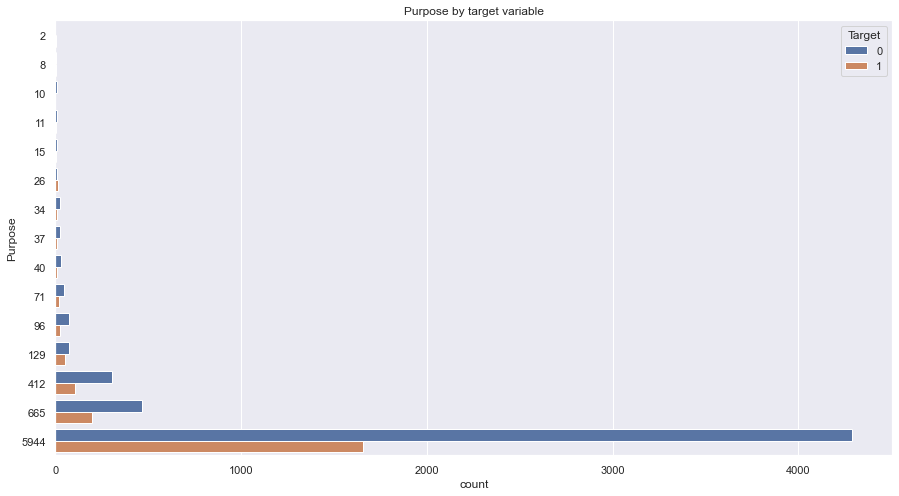

In [16694]:
plt.figure(figsize=(15,8))

sns.countplot(y="Purpose", hue=TARGET_NAME, data=df)
plt.title('Purpose by target variable')
plt.legend(title='Target', loc='upper right')
plt.show()

In [16695]:
df.loc[df['Purpose'] < (df['Purpose'].max() * 0.025), 'Purpose'] = df['Purpose'].mode()[0]

In [16696]:
test_df.loc[test_df['Purpose'] < (test_df['Purpose'].max() * 0.025), 'Purpose'] = test_df['Purpose'].mode()

In [16697]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   int64   
 1   Annual Income                 7500 non-null   float32 
 2   Years in current job          7500 non-null   int64   
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  7500 non-null   float32 
 9   Bankruptcies                  7500 non-null   float32 
 10  Purpose                       7500 non-null   int64   
 11  Term                          7500 non-null   int64   
 12  Current Loan Amount           7500 non-null   fl

### Добавим ID<a class="anchor" id="new_features"></a>

In [16698]:
df['ID'] = df.index.tolist()

In [16699]:
test_df['ID'] = test_df.index.tolist()

**Dummies**

поскольку выбрана модель CatBoostClassifier, смысла в преобразовании Dummies нет.

In [16700]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   int64   
 1   Annual Income                 7500 non-null   float32 
 2   Years in current job          7500 non-null   int64   
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  7500 non-null   float32 
 9   Bankruptcies                  7500 non-null   float32 
 10  Purpose                       7500 non-null   int64   
 11  Term                          7500 non-null   int64   
 12  Current Loan Amount           7500 non-null   fl

### Сохранение обучающего датасета<a class="anchor" id="saving"></a>

In [16701]:
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [16702]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,AI_nan,K_AI_MD,MSLD_nan,B_nan,CS_target,ID
0,647,482087.0,371,0.0,11.0,26.3,685960.0,1.0,9999.0,1.0,...,47386.0,7914.0,749.0,0,0,60.915718,1,0,0,0
1,647,1025487.0,2332,0.0,15.0,15.3,1181730.0,0.0,9999.0,0.0,...,394972.0,18373.0,737.0,1,0,55.814890,2,0,0,1
2,3637,751412.0,339,0.0,11.0,35.0,1182434.0,0.0,9999.0,0.0,...,308389.0,13651.0,742.0,0,0,55.044464,1,0,0,2
3,647,805068.0,426,0.0,8.0,22.5,147400.0,1.0,9999.0,1.0,...,95855.0,11338.0,694.0,0,0,71.006170,4,0,0,3
4,3204,776264.0,339,0.0,13.0,13.6,385836.0,1.0,9999.0,0.0,...,93309.0,7180.0,719.0,0,0,108.114760,2,0,0,4


### Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

**Выделение целевой переменной и групп признаков**

In [16703]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

**Матрица корреляций (на исходном датасете)**

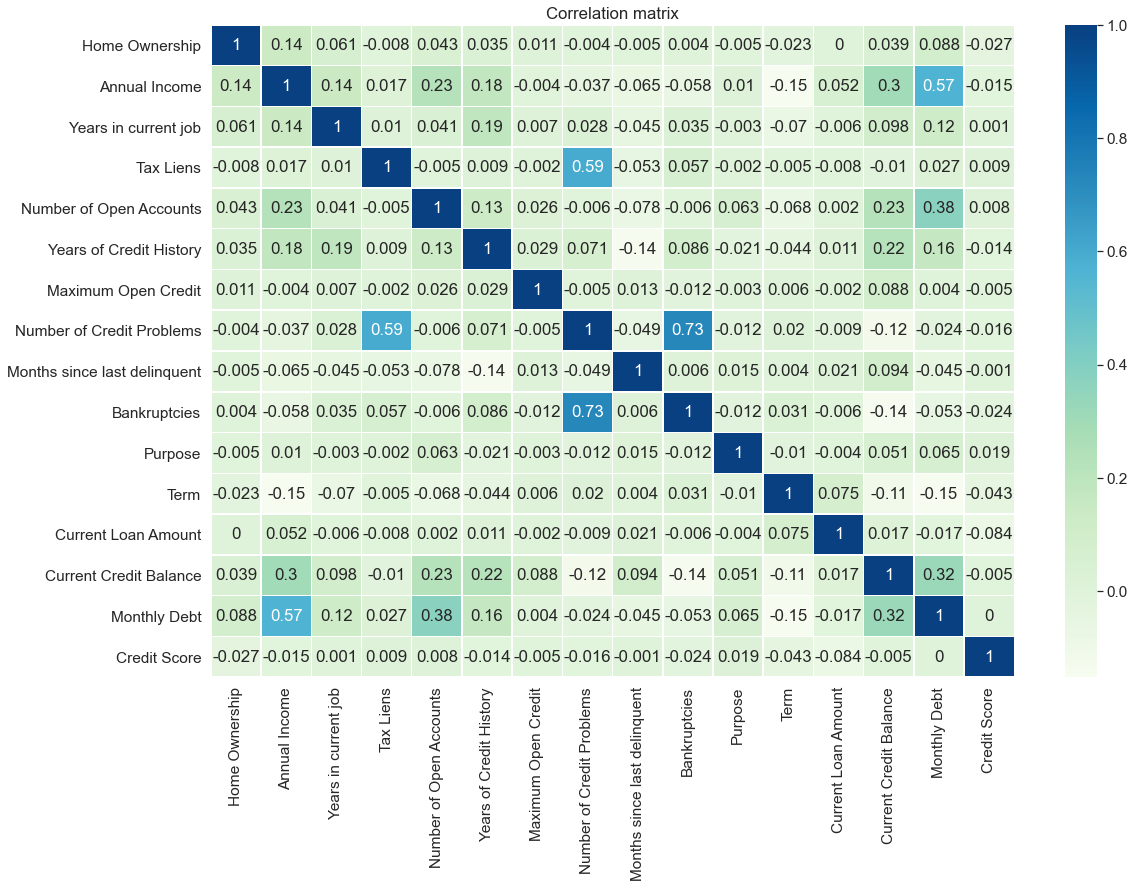

In [16704]:
plt.figure(figsize = (18,12))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [16705]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [16706]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [16707]:
# input
# output
TRAIN_FULL_PATH = '../course_project/course_project_train_full.csv'
TRAIN_PART_PATH = '../course_project/course_project_train_part_tr.csv'
TEST_PART_PATH = '../course_project/course_project_train_part_ts.csv'
SCALER_FILE_PATH = '../course_project/scaler.pkl'
MODEL_FILE_PATH = '../model.pkl'

In [16708]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,AI_nan,K_AI_MD,MSLD_nan,B_nan,CS_target,ID
0,647,482087.0,371,0.0,11.0,26.3,685960.0,1.0,9999.0,1.0,...,47386.0,7914.0,749.0,0,0,60.915718,1,0,0,0
1,647,1025487.0,2332,0.0,15.0,15.3,1181730.0,0.0,9999.0,0.0,...,394972.0,18373.0,737.0,1,0,55.814890,2,0,0,1
2,3637,751412.0,339,0.0,11.0,35.0,1182434.0,0.0,9999.0,0.0,...,308389.0,13651.0,742.0,0,0,55.044464,1,0,0,2
3,647,805068.0,426,0.0,8.0,22.5,147400.0,1.0,9999.0,1.0,...,95855.0,11338.0,694.0,0,0,71.006170,4,0,0,3
4,3204,776264.0,339,0.0,13.0,13.6,385836.0,1.0,9999.0,0.0,...,93309.0,7180.0,719.0,0,0,108.114760,2,0,0,4


### Выделение целевой переменной и групп признаков<a class="anchor" id="feature_selection"></a>

In [16709]:
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [16710]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES +CAT_FEATURE_NAMES

### Приведение типов для модели CatBoost

In [16711]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

In [16712]:
for colname in CAT_FEATURE_NAMES:
    test_df[colname] = pd.Categorical(test_df[colname])
    
test_df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

### Нормализация данных<a class="anchor" id="normalization"></a>

In [16713]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [16714]:
scaler = StandardScaler()

df_norm = test_df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

test_df = df_norm.copy()

### Сохранение модели для нормализации данных<a class="anchor" id="train_and_test"></a>

In [16715]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [16716]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [16717]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [16718]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [16719]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [16720]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

In [16721]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### Загрузка подготовленных датасетов<a class="anchor" id="data_loading"></a>

**Загрузка данных**

In [16722]:
df = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

**Выделение признакового описания и целевой переменной**

In [16723]:
X = df.drop(columns=CAT_FEATURE_NAMES + ['ID', TARGET_NAME])
y = df[TARGET_NAME]

X_train = df_train.drop(columns=TARGET_NAME)
y_train = df_train[TARGET_NAME]

X_test = df_test.drop(columns=TARGET_NAME)
y_test = df_test[TARGET_NAME]

### После снижения степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [16724]:
final_model_x = catb.CatBoostClassifier(n_estimators=500, max_depth=1,
                                      l2_leaf_reg=12, class_weights=[1, 1.03],
                                      silent=True, random_state=21)
final_model_x.fit(X_train, y_train, CAT_FEATURE_NAMES)

y_train_pred = final_model_x.predict(X_train)
y_test_pred = final_model_x.predict(X_test)
y_test_pred_probs = final_model_x.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      3771
           1       0.71      0.54      0.61      2958

    accuracy                           0.70      6729
   macro avg       0.70      0.68      0.68      6729
weighted avg       0.70      0.70      0.69      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1616
           1       0.54      0.54      0.54       634

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1321  295
1                291  343


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [16725]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model_x, file)

In [16726]:
def save(model,df_test):
  sub_pred = model.predict(df_test)
  df_test['id'] = df_test.index
  submit = pd.DataFrame({'id':df_test['id'], 'Credit Default':sub_pred}, dtype=np.int32)
  submit.to_csv('../course_project/Evstafyev_predictions.csv', index=False) 
  df_test = df_test.drop('id', axis=1)  
  
  print(f'Сохранено')

In [16727]:
save(final_model_x , df_test)

Сохранено
